# MODELO SEIR - Covid-19 Bogotá

In [1]:
# =================================== LIBRERIAS =========================================
# Importando librerias requeridas.
import matplotlib.pyplot as plt
import patchsim as sim
import datetime as dt
import pandas as pd
import numpy as np
import nlopt
import time
import csv

In [2]:
# ================================ARCHIVO CONFIG.TXT ============================================

# Hay dos configuraciones de prueba básicas (determinista y estocástica) en la carpeta de
# prueba. La configuraciòn determinista tiene el siguiente aspecto:

# CARACTERISTICAS:
#
#   ARCHIVOS:
#     PatchFile: Pop.txt    --->   Definido posteriormente
#     NetworkFile: Net.txt  --->   Definido posteriormente
#     SeedFile: Seeds.txt   --->   Definido posteriormente
#     ParamFile: Param.txt  --->   Definido posteriormente
#     NetworkType: 
#        • PatchSim actualmente acepta tres tipos de red diferentes: 
#          Dependiendo del NetworkType, el <time_index> en NetworkFile toma los siguientes valores.
#             - Estático: <time_index> es siempre 0.
#             - Mensual: <time_index> toma todos los valores de [0, 11] --> (0 = enero).
#             - Semanal: <time_index> toma todos los valores de [0, 52] --> (0 = 1 al 7 de enero)
#   PARAMETROS
#     Los parámetros de enfermedad ExposureRate, InfectionRate y RecoveryRate generalmente se 
#     enumeran en el archivo de configuración. 
#   CICLO DE TIEMPO
#     El ciclo simulado es desde: StartDate = 1 (01/01/2020), con una duracion de 500 dias.

dia1 = pd.to_datetime("01/01/2020", format="%d/%m/%Y") 
dia2 = pd.to_datetime("01/09/2020", format="%d/%m/%Y") 
dias1 = (dia2-dia1).days # 244 dias

def get_config(beta, symprob):
    loc="config1/"
    config = {"PatchFile":loc+"pop.txt",
              "NetworkFile":loc+"net.txt",
              "SeedFile":loc+"seeds.txt",
              "ParamFile":loc+"param.txt",
              "NetworkType":"Weekly",
              
              "ExposureRate2":beta,
              "InfectionRate":0.2173,
              "RecoveryRate":0.47,
              "SymptomaticProbability":symprob,
              
              "StartDate":1,
              "Duration":500,
              
              "Model":"Mobility",
              "LoadState":"False",
              "SaveState":"True",
              "SaveDay":244, # Dia a salvar la matriz de estados.
              "SaveFile":loc+"state.npy",
              
              "OutputFile":loc+"resultados.out",
              "OutputFormat":"Whole",
              "LogFile":loc+"proceso.log"
             }
    w = csv.writer(open(loc+"cfg.txt", "w"))
    [w.writerow([key, val]) for key, val in config.items()]
    return config

In [3]:
# ================================ARCHIVO POP.TXT =====================================

# Contiene los tamaños de la población de cada localidad en el siguiente formato para
# cada línea: <localidad_id> <tamaño_población>

def write_pop(localidades, file="config1/pop.txt"):
    df = pd.DataFrame( {"id_localidades":localidades["local_id"].values, 
                             "poblacion":localidades[ "Pop2020" ].values})
    df.to_csv(file, header = False, index = False, sep=' ')
    print("Hay {:,.0f} personas en las 19 localidades.".format(df["poblacion"].sum()))

In [4]:
# ================================ARCHIVO NET.TXT =====================================

# NetworkFile Contiene la matriz de viajes en el siguiente formato para cada línea:
# <localidad_id_i> <localidad_id_j> <time_index> <Theta_i,j> donde:
#      <loc_id_i> y <loc_id_j> son el id de la localidad i, y el id de la localidad j.
#      <time_index> lo hará tomar valores diferentes según el tipo de red (NetworkType).
#      <Theta_i,j> La cantidad de personas que viajan de la localidad i a la j.

def write_net(redes, file="config1/net.txt",
             ratios=pd.DataFrame(),
             disminuye_movilidad_60=False,
             movilidad="semanal"):    
    
    nxn = len(redes)  #19x19
    dias = np.zeros(nxn, dtype=int) 
    hbw = redes["hbw"].values
    ratio = np.ones((53, 19))
    
    # Movilidad tiempo 0 -- Normalizando matriz.
    W = hbw.reshape(-1,19) # Matriz 19x19 Viaje localidad i a j.
    for i in range(19):  
        total_i = np.sum(W[i,:]) # Total en localidad i
        W[i,:] = W[i,:]/total_i
    hbw=W.reshape(-1)
    K = 1 # Movilidad estatica
    
    if movilidad == "semanal": 
        K = 53
        # Definiendo vector "ratios" para disminuir movilidad al 60% semanalmente
        if disminuye_movilidad_60:
            ratio = ratio * 0.60

        # Definiendo Vector "ratios" para disminuir movilidad segun un radio semanalmente
        if ratios.empty == False:
            for index, row in ratios.iterrows(): 
                ratio[int(row.week)-1, int(row.loc_id)-1]=row.ratio  

        # Disminuyendo matriz inicial segun vector de ratios semanalmanete
        for k in range(1,53):  
            W1 = np.zeros((19,19))
            for i in range(19):
                W1[i,:] = W[i,:]*ratio[k,i]
                W1[i,i] = 0
                W1[i,i] = 1 - W1[i,:].sum()
            W = W1.copy()
            hbw = np.append(hbw, W1.reshape(-1))
            dias = np.append(dias, np.zeros(nxn, dtype=int)+k)
    
    #-----------------------------------------------------------------------------------------
    df = pd.DataFrame( {"origen":list(redes["o_loc"].values)*K,
                        "destino":list(redes["d_loc"].values)*K, 
                        "semana":dias,
                        "hbw":hbw})
    
    df.to_csv(file, header = False, index = False, sep=' ')

In [5]:
# ================================ARCHIVO PARAM.TXT =====================================

#  Parámetros espacio-temporales: 
#  Si los usuarios desean utilizar valores heterogeneos de ExposureRate (beta) para 
#  localidades específicas, o hacer que varíe con el tiempo, entonces se puede incluir un
#  Atributo ParamFile, que apunta a un archivo.

def write_param(ratios, file="config1/param.txt"):

    # Matriz dias x localidad, cada item contiene radio de disminucion
    ratio = np.ones((53*7, 19))
    
    for index, row in ratios.iterrows(): 
        i, j = int(row.week)*7, int(row.loc_id)-1
        ratio[i:i+7,j] = row.ratio 
    
    df = pd.DataFrame(ratio).T 
    df.insert(0, "id", np.arange(19)+1, True)
    df.to_csv(file, header = False, index = False, sep=' ')

In [6]:
# =====================================ARCHIVO SEED.TXT ========================================

# SeedFile Contiene el cronograma de semillas (obligatorio) en el siguiente formato para cada 
# línea: <day> <localidad_id> <seed_cases>

def write_seed(Casos, file="config1/seeds.txt"):

    # Renombrando columnas
    casos = Casos.rename(columns={"LOCALIDAD_ASIS": 'Localidad',
                                  "FECHA_DE_INICIO_DE_SINTOMAS":'fecha'})
                                  #"FECHA_DIAGNOSTICO":'fecha'})
        
    # Convirtiendo en formato fecha de pandas
    casos["fecha"] = pd.to_datetime(casos["fecha"], format="%d/%m/%Y")  # to DateTime
    print("Dia 1 del inicio de sintomas:", casos["fecha"].min())

    # Calculando el tiempo transcurrido en dias
    dia1 = pd.to_datetime("01/01/2020", format="%d/%m/%Y")
    tiempo = casos["fecha"] - dia1 # Tiempo transcurrido
    casos['dia'] = tiempo.dt.days 
    casos.dropna(subset=['dia'], inplace=True)
    casos.dia = casos['dia'].apply(np.int)

    # Uniendo base de datos localidades y número de casos
    datos = pd.merge(casos, localidades, on='Localidad')  # Uniendo datos by id: "localidades".

    #  Aplicando función gamma (5)
    datos["dia"] = datos["dia"].apply(lambda x: x-int(np.random.gamma(5)))

    # Encontrando cantidad de casos por dia y localidad
    Ncasos = datos.groupby(['dia', 'local_id']).size().reset_index(name='n_casos_real') 

    #------------------------------------------------------------------------------------------------------------
    #  Generando archivo Semillas: Cantidad de infectados en los primeros 60 dias para cada localidad.
    df = Ncasos[Ncasos["dia"]<=70]
    df.reset_index(drop=True, inplace=True)
    df.to_csv(file, header = False, index = False, sep=' ')
    print("Cantidad de semillas iniciales:", len(df))
    return Ncasos

In [7]:
# =========================================== GRAFICAR ========================================================
def graficar(casos_real, casos_sim, symprob, fechas=False, individual=False, dummy=0):
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0, 1, 19)]
    # Graficos
    if individual:
        fig, ax = plt.subplots(5,4,figsize=(15,13),dpi=100)
        ax = ax.reshape(-1)
    else: fig, [ax1,ax2] = plt.subplots(1,2,figsize=(12,4),dpi=120)
    for i in np.arange(19)+1:
        #-------------------------------------------------------------------
        # Casos reales
        loc = casos_real[casos_real["local_id"]==i] # Localidad i
        casos = loc["n_casos_real"].values
        tiempo = loc["dia"].values
        if individual: ax[i-1].plot(tiempo, casos, '.', label="Reales", color=colors[-(i-1)])
        else: ax1.plot(tiempo, casos, label="Reales", color=colors[-(i-1)])
        #--------------------------------------------------------------------
        # Casos simulaciones
        infectados = casos_sim[casos_sim.index==str(i)].values[0]
        t = casos_sim.columns + dummy
        if individual: 
            ax[i-1].plot(t, symprob*infectados, label="Infectados", lw=3, color="red")
        else: 
            ax2.plot(t, symprob*infectados, lw=3, color=colors[-(i-1)], 
                       label=str(localidades["Localidad"][i-1]) + " - Loc"+str(i))
        #---------------------------------------------------------------------
        # Propiedades gráficas
        if individual: ax[i-1].set_title(str(localidades["Localidad"][i-1]) +
                                         " - Loc"+str(i), fontsize=11)
    for axs in plt.gcf().get_axes():
        axs.set_xlabel("dias")
        axs.set_ylabel("número de infectados")
        axs.set_xlim(0,500)
        axs.grid()
    if fechas:
        dia1 = pd.to_datetime("01/01/2020", format="%d/%m/%Y")
        fechas = casos_real["dia"].apply(lambda x: (dia1+dt.timedelta(days=x)).strftime("%d/%m/%Y"))
        dias = lambda ax: [(dia1+dt.timedelta(days=i)).strftime("%d/%b/%Y") for i in ax.get_xticks()]
        [axs.set_xticklabels(dias(axs), rotation=60) for i in plt.gcf().get_axes()]
    if individual:
        ax[-1].axis("off")
        fig.tight_layout()
        return ax
    ax1.set_title("Casos de Covid 19 en Bogotá - Reales", c="r")
    ax2.set_title("Casos de Covid 19 en Bogotá - Simulados", c="r")
    ax2.legend(loc="right", bbox_to_anchor=(1.5,0.5), fontsize=8.3)
    [axs.set_xticks(np.linspace(0,500,11)) for axs in plt.gcf().get_axes()]
    return ax1, ax2

In [8]:
# ========================================= OPTIMIZACION ========================================================

def simular(x, grad):
    
    beta, symprob = x[0], x[1]
    
    # Corriendo simulacion
    configs = f(beta, symprob)
    casos_sim = sim.run_disease_simulation(configs, write_epi=True, return_epi=True)

    # Infectados simulados:
    x, y = np.meshgrid(casos_sim.columns, casos_sim.index)
    inf = pd.DataFrame(
        np.transpose([x.ravel(),y.ravel(),casos_sim.values.ravel()]), 
        columns=["dia", "local_id", "n_casos_sim"], dtype=int)
    
    # DataFrame de Infectados reales y simulados
    Inf = pd.merge(inf, casos_reales, on=['dia','local_id'],  how='right')
    
    # Mean Square Error   
    Inf_rango = Inf[(Inf["dia"]>=T1)&(Inf["dia"]<=T2)]
    Error = (Inf_rango["n_casos_real"] - symprob*Inf_rango["n_casos_sim"])**2
    return Error.mean()

# Optimizacion:
def Optimizar():
    n = 2 # Numero de variables a optimizar : Beta y SymProb
    Nitr = 1000 # Numero maximo de iteraciones 

    inf = [0.5, 0.01] # Limites inferiores
    sup = [10, 1]  # Limites superiores

    opt = nlopt.opt(nlopt.LN_NELDERMEAD, n)
    opt.set_lower_bounds(inf)
    opt.set_upper_bounds(sup)
    opt.set_maxeval(Nitr)
    opt.set_min_objective(simular)
    opt.set_xtol_rel(1e-5)
    x0 = np.array([3, 0.1])
    x = opt.optimize(x0)
    return x

# SIMULACIÓN - PRIMER PICO

### EJECUTANDO FUNCIÓN PATCHSIM

In [9]:
# Leyendo archivos
localidades = pd.read_csv("Datos/info_local_2020.csv")
redes = pd.read_csv("Datos/cdr_od_loc.csv")
ratios = pd.read_csv("Datos/agregados_grandata_localidad.csv")
Semillas = pd.read_csv("Datos/osb_enftransm-covid-19_17042021.csv", 
                       nrows=732872, encoding='latin-1', delimiter=";")

In [10]:
# Escribiendo archivos
write_pop(localidades)
write_net(redes, ratios=ratios)
write_param(ratios)
casos_reales = write_seed(Semillas)
print("El segundo pico inicia en el dia %i del año 2020"%(244))

Hay 6,907,683 personas en las 19 localidades.
Dia 1 del inicio de sintomas: 2020-02-26 00:00:00
Cantidad de semillas iniciales: 97
El segundo pico inicia en el dia 244 del año 2020


In [11]:
# Optimizando beta y symprob
ti = time.time()
D, T1, T2, f = 0, 60, 260, get_config
x_opt = Optimizar()
e = simular(x_opt,0)
tf = time.time()
print("beta*=%.5f, symprob*=%.5f, error=%.3f, execution_time=%.2f seg"%(x_opt[0], x_opt[1], e, tf-ti))
print(x_opt)

beta*=8.16328, symprob*=0.05487, error=1526.009, execution_time=14.57 seg
[8.16328243 0.05487186]


In [12]:
# Corriendo simulacion
beta, symprob = x_opt
configs = get_config(beta, symprob)
casos_sim = sim.run_disease_simulation(configs, write_epi=True, return_epi=True)

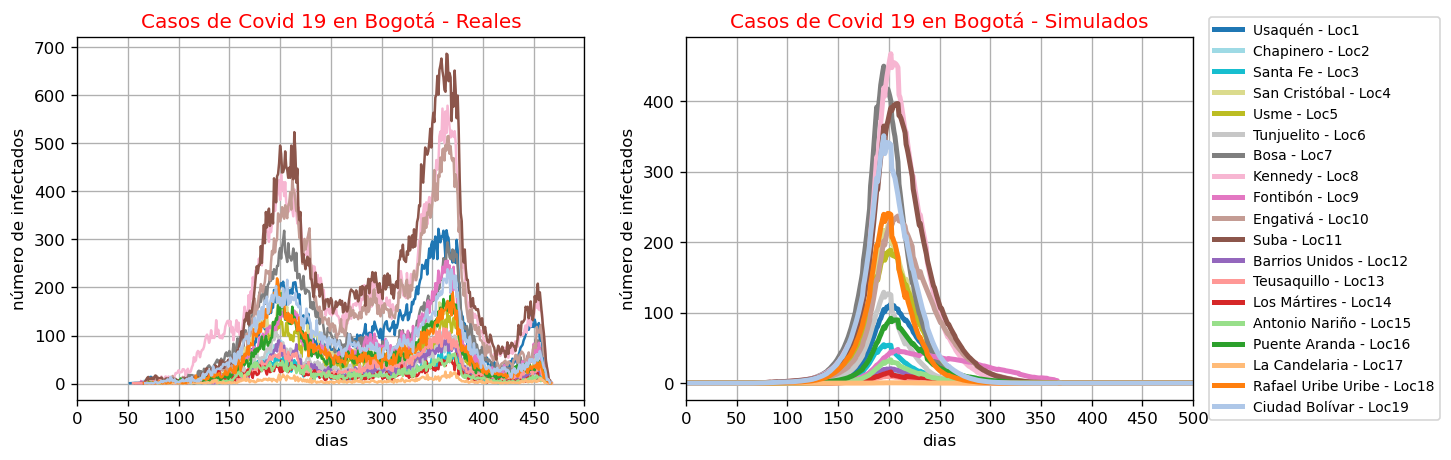

In [13]:
# Grafica grupal:
[ax1, ax2] = graficar(casos_reales, casos_sim, symprob)

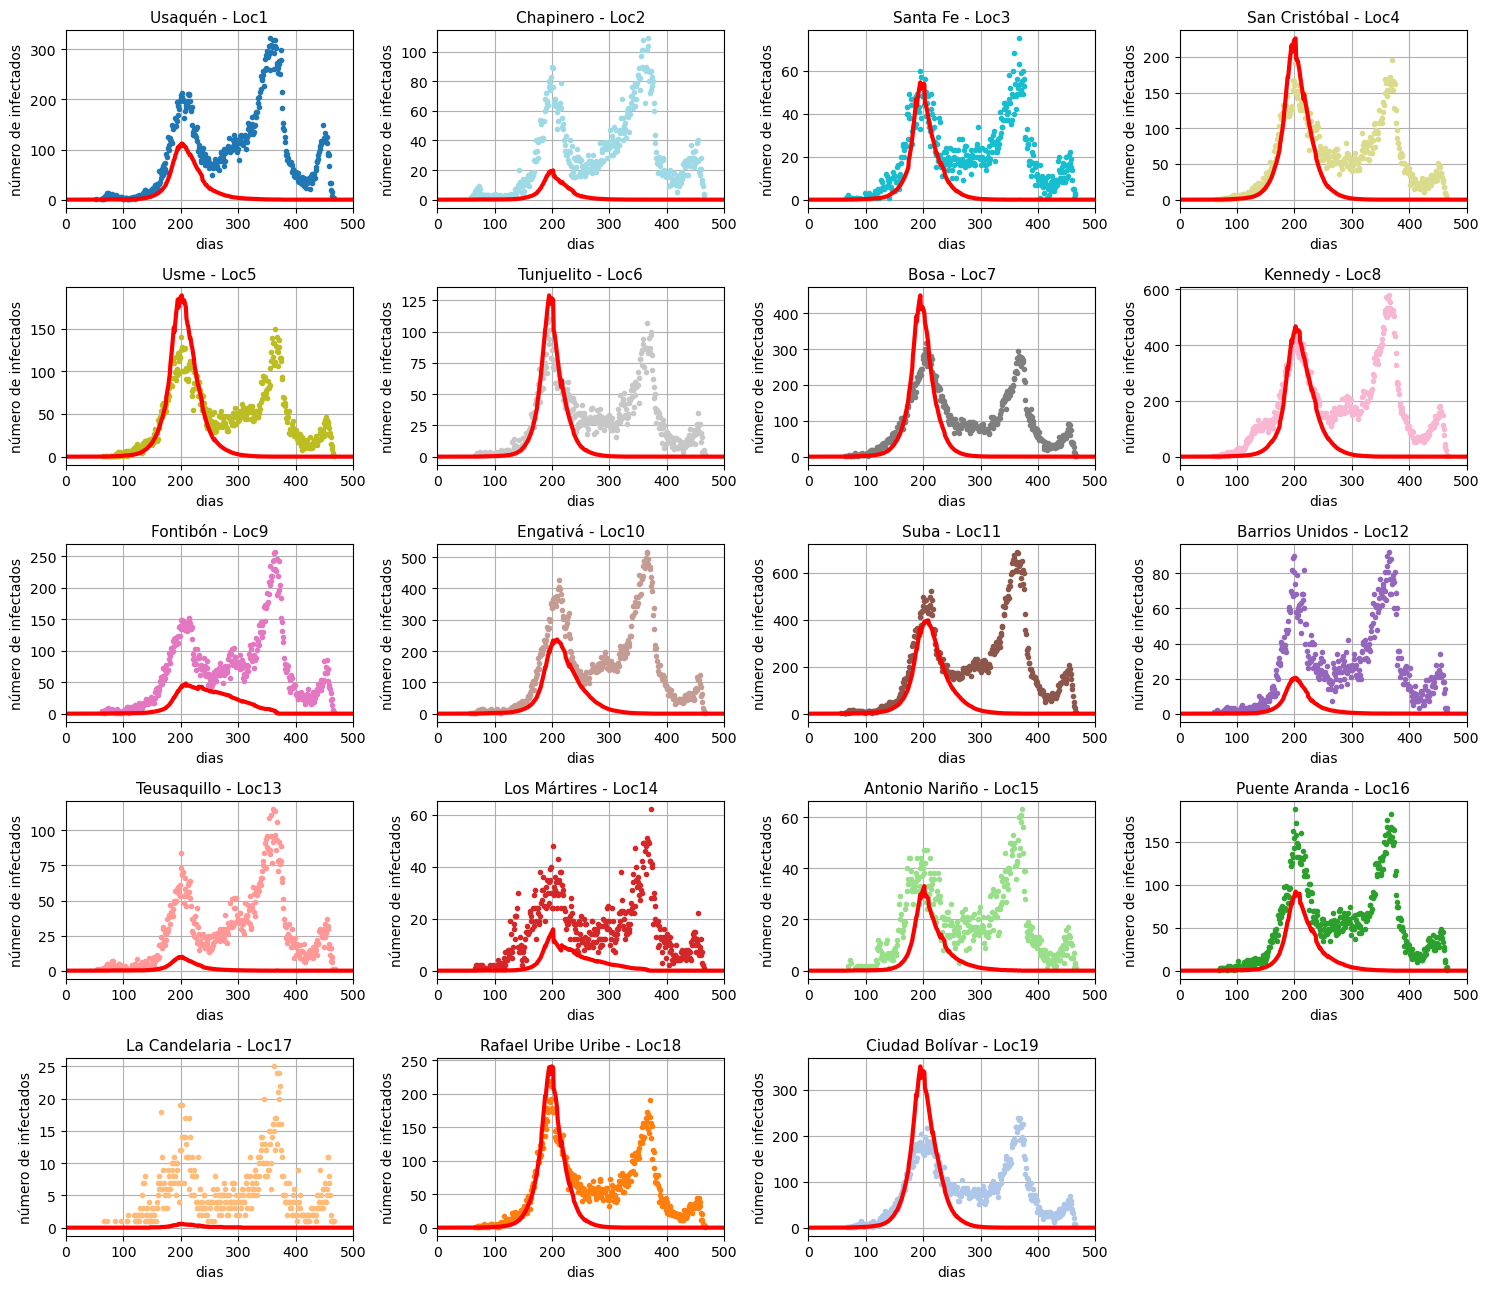

In [14]:
# Grafica individual:
ax = graficar(casos_reales, casos_sim, symprob, individual=True)

**Conclusiones**

* Al no incluir la movilidad, la simulación se ajusta más a la realidad.
* Al incluir la movilidad, las localidades con mayor flujo de personas son las que menos se ajustan a la realidad, lo cuál es interesante debido a que mayor granularidad no es necesario modelar el contacto. De esta forma podemos probar una estrategia de mitigación de riesgos.

# SIMULACIÓN - SEGUNDO PICO

In [15]:
def get_config2(beta, symprob):
    loc="config2/"
    config = {"PatchFile": "config1/pop.txt",
              "NetworkFile":"config2/net.txt",
              #"ParamFile":"config2/param.txt", Sin incluir movilidad
              "NetworkType":"Weekly",
              
              "ExposureRate":beta, ##  Cambiar a ExposureRate2 si se incluye ParamFile
              "InfectionRate":0.2173,
              "RecoveryRate":0.47,
              "SymptomaticProbability":symprob,
              
              "StartDate":244,
              "Duration":500,
              
              "Model":"Mobility",
              "LoadState":"True",
              "LoadFile":"config1/state.npy",
              "SaveState":"False",
              
              "OutputFile":loc+"resultados.out",
              "OutputFormat":"Whole",
              "LogFile":loc+"proceso.log"
             }
    w = csv.writer(open(loc+"cfg.txt", "w"))
    [w.writerow([key, val]) for key, val in config.items()]
    return config

In [16]:
X = np.load("config1/state.npy")  # S E A I R new_inf
X[-1]

array([ 527.98688864, 1997.19266057, 2518.20021006,   75.75857416,
         35.36765094,  110.24226113,  133.69699352,  475.04914048,
          3.12026097,  505.67907884, 1010.91195234,   58.41969028,
        147.93540304,  754.60734509,  774.90230461,  227.29723456,
        720.65237573, 2340.61400964,  684.39426071])

In [17]:
casos_reales["dia"] = casos_reales["dia"] - 244
casos_reales = casos_reales[casos_reales["dia"] > 0]
casos_reales

,dia,local_id,n_casos_real
3245,1,1,79
3246,1,2,29
3247,1,3,16
3248,1,4,75
3249,1,5,45
...,...,...,...
7448,223,10,1
7449,223,15,1
7450,223,17,1
7451,223,18,1


In [18]:
# Semana 1-sept 
semana = 244//7  ## Semana 34

In [19]:
# Contando nuevos radios (alphas) desde semana 34 
rad = pd.read_csv("Datos/agregados_grandata_localidad.csv")
rad = rad[rad["week"]>=semana]
rad["week"] -= semana # semana 34 ahora es semana 0.

In [20]:
## NetworkFile: Matriz de viajes.
net = pd.read_csv("config1/net.txt", sep=" ", header=None)
net.columns = ["o_loc", "d_loc", "week", "hbw"]
net = net[net["week"]==semana]
write_net(net, ratios=rad, file="config2/net.txt")

In [21]:
## ParamFile:
write_param(rad, file="config2/param.txt")

In [22]:
# Corriendo simulacion
beta, symprob = [9.98648825, 0.06228269]
configs = get_config2(beta, symprob)
casos_sim = sim.run_disease_simulation(configs, write_epi=True, return_epi=True)

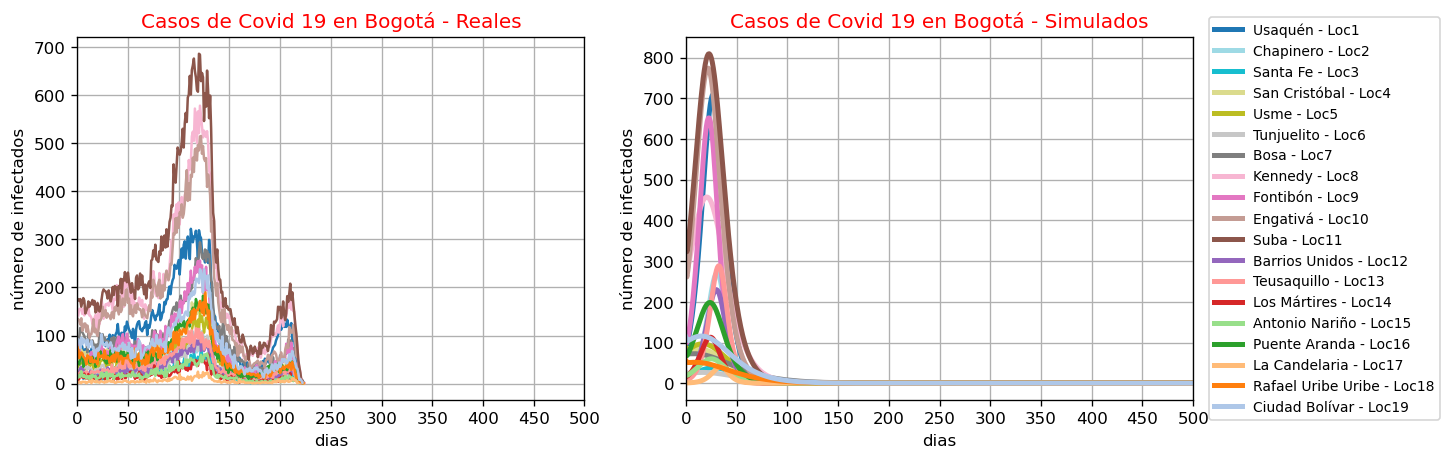

In [23]:
# Grafica grupal:
[ax1, ax2] = graficar(casos_reales, casos_sim, symprob)

In [24]:
# ========================================= OPTIMIZACION ========================================================

def simular(x, grad):
    
    beta, symprob = x[0], x[1]
    
    # Corriendo simulacion
    configs = get_config2(beta, symprob)
    casos_sim = sim.run_disease_simulation(configs, write_epi=True, return_epi=True)

    # Infectados simulados:
    x, y = np.meshgrid(casos_sim.columns, casos_sim.index)
    inf = pd.DataFrame(
        np.transpose([x.ravel(),y.ravel(),casos_sim.values.ravel()]), 
        columns=["dia", "local_id", "n_casos_sim"], dtype=int)
    
    # DataFrame de Infectados reales y simulados
    Inf = pd.merge(inf, casos_reales, on=['dia','local_id'],  how='right')
    
    # Mean Square Error   
    Inf_rango = Inf[(Inf["dia"]>=0)&(Inf["dia"]<=90)]
    Error = (Inf_rango["n_casos_real"] - symprob*Inf_rango["n_casos_sim"])**2
    return Error.mean()

# Optimizacion:
def Optimizar():
    n = 2 # Numero de variables a optimizar : Beta y SymProb
    Nitr = 1000 # Numero maximo de iteraciones 

    inf = [0.5, 0.01] # Limites inferiores
    sup = [10, 1]  # Limites superiores

    opt = nlopt.opt(nlopt.LN_NELDERMEAD, n)
    opt.set_lower_bounds(inf)
    opt.set_upper_bounds(sup)
    opt.set_maxeval(Nitr)
    opt.set_min_objective(simular)
    opt.set_xtol_rel(1e-5)
    x0 = np.array([3, 0.1])
    x = opt.optimize(x0)
    return x

Optimizar()

array([7.20621253, 0.05628777])

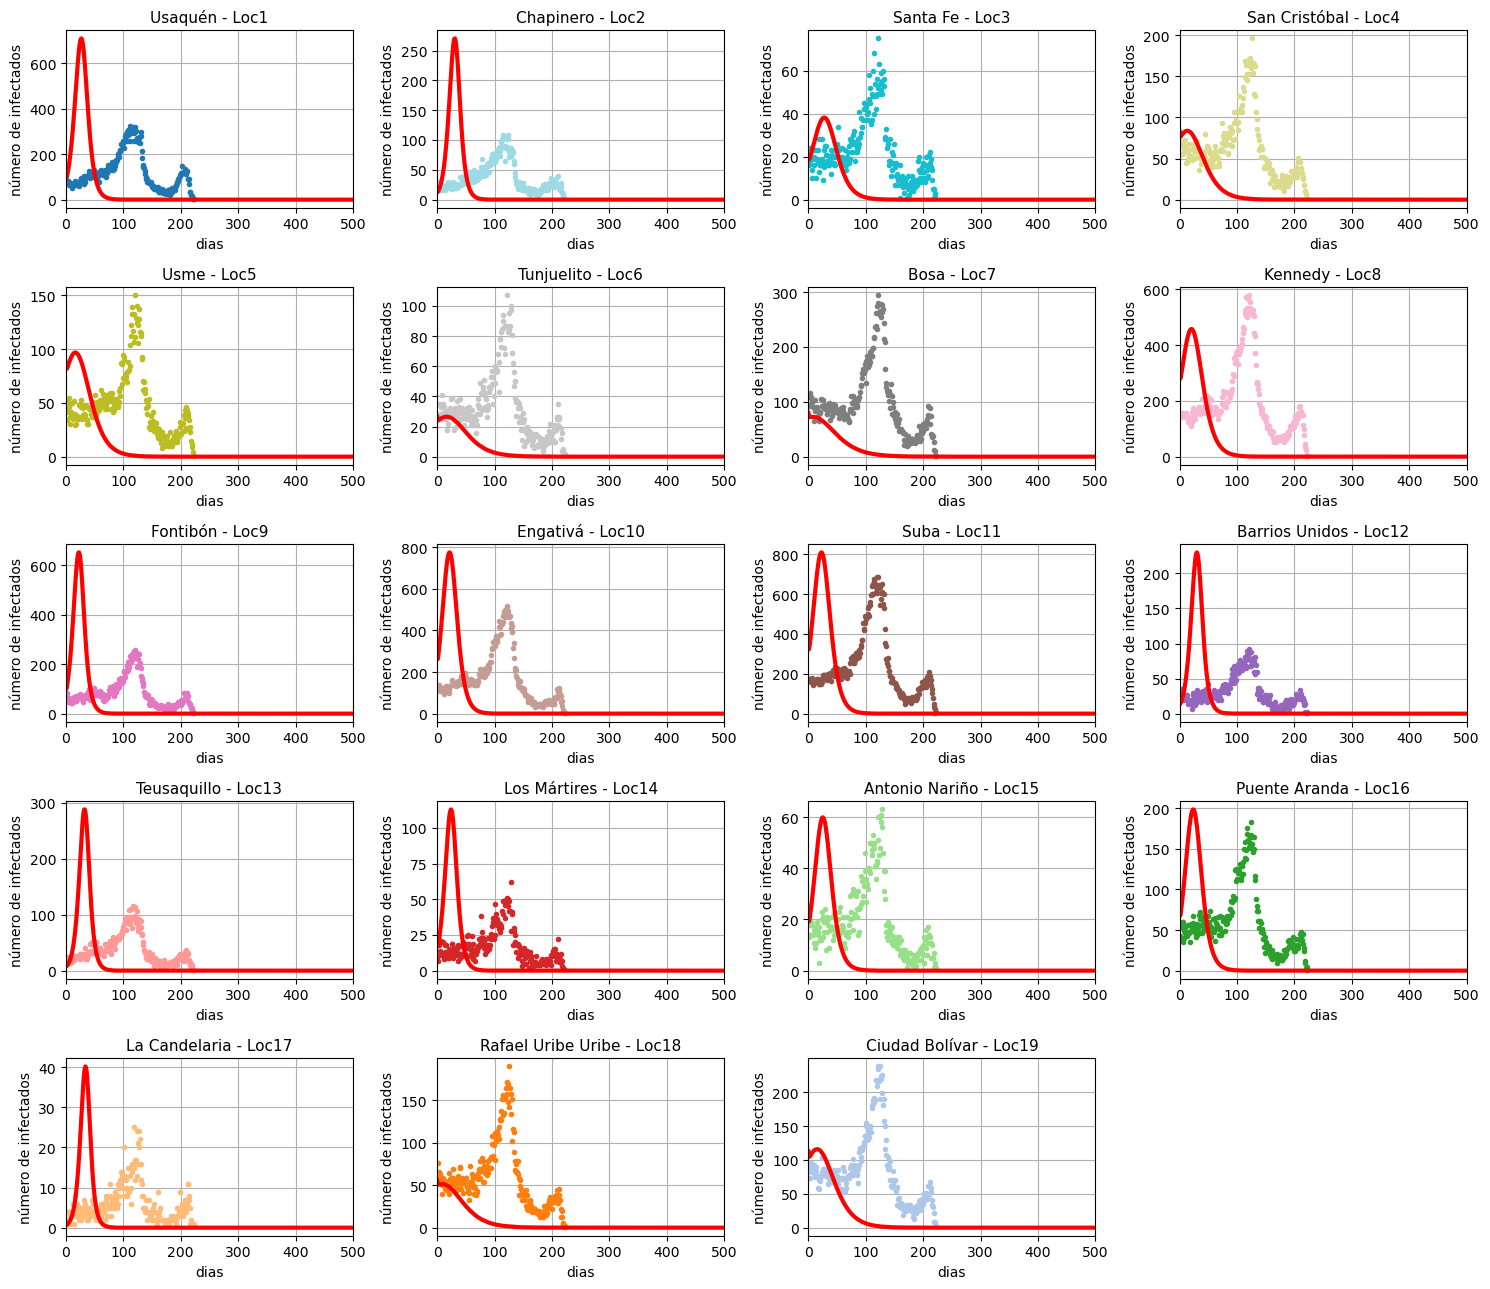

In [25]:
# Grafica individual:
ax = graficar(casos_reales, casos_sim, symprob, individual=True)

# Objetivos:

* Proponer estrategias de mitigación para reducir los contagios.
* Modelar el segundo pico.
* Graficar datos externos de la ciudad
* Reemplazar ParamFile, con datos de Google